In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Dense, InputLayer
import numpy as np
from PIL import Image
from tensorflow.keras.optimizers import Adam
import os
##from tensorflow.keras.layers.experimental.preprocessing import RandomFlip, RandomRotation, RandomZoom
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, BatchNormalization, MaxPooling2D, Flatten, Dropout, Dense, Input
from tensorflow.keras.regularizers import l2
from keras import regularizers
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import seaborn as sns
from tensorflow.keras.models import Model

In [2]:
BATCH_SIZE = 16
IMAGE_SIZE = 128

In [3]:
def preprocess_image(image, label):
    image = tf.keras.applications.vgg19.preprocess_input(image)

    image = tf.image.resize(image, (IMAGE_SIZE, IMAGE_SIZE))

    return image, label

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
!ls "/content/drive/My Drive/"

'Colab Notebooks'   Dataset1.zip   dataset3.zip   dataset.zip
 dataset_1.zip	    Dataset2.zip   dataset4.zip   fake_news_dataset.zip


In [6]:
import zipfile

# Define the path to the zip file and the extraction directory
zip_file_path = '/content/drive/My Drive/Dataset2.zip'
extraction_path = '/content/Dataset'

# Unzip the file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extraction_path)

In [7]:
dataset_path = "/content/Dataset"

In [8]:
full_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_path,
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE
).map(preprocess_image)
dataset_size = tf.data.experimental.cardinality(full_dataset).numpy()
subset_size = int(1.0 * dataset_size)

# Take 20% of the dataset
dataset = full_dataset.take(subset_size)

Found 5000 files belonging to 5 classes.


In [9]:
class_names = sorted(os.listdir(dataset_path))

print(class_names)

['basophil', 'erythroblast', 'monocyte', 'myeloblast', 'seg_neutrophil']


In [10]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(16, 128, 128, 3)
[4 1 1 2 1 3 3 0 0 0 1 0 1 4 0 3]


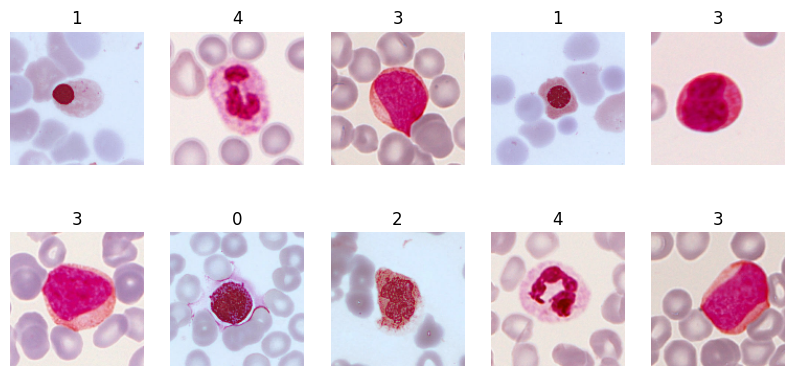

In [11]:
for images, labels in dataset.take(1):
    plt.figure(figsize=(10, 10))

    num_images = min(10, images.shape[0])

    for i in range(num_images):
        ax = plt.subplot(4, 5, i + 1)
        img = images[i].numpy()

        if img.min() < 0 or img.max() > 1:
            img = ((img - img.min()) / (img.max() - img.min()) * 255).astype("uint8")
        else:
            img = (img * 255).astype("uint8")

        plt.imshow(img)
        plt.title(int(labels[i]))
        plt.axis("off")

    plt.show()
    break

In [12]:
len(dataset)

313

In [13]:
def get_dataset_partitions_tf(ds, train_split=0.7, val_split=0.15, test_split=0.15, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1

    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds

In [14]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [15]:
len(train_ds)

219

In [16]:
len(val_ds)

46

In [17]:
len(test_ds)

48

In [18]:
def custom_augmentation(image, label):

    # Random flip
    image = tf.image.random_flip_left_right(image)

    #Random brightness and contrast adjustment
    # image = tf.image.random_brightness(image, max_delta=0.1)
    # image = tf.image.random_contrast(image, lower=0.9, upper=1.0)

    # Random rotation
    image = tf.image.rot90(image, k=tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32))

    return image, label

train_ds = train_ds.map(custom_augmentation, num_parallel_calls=tf.data.AUTOTUNE)

In [19]:
train_ds = train_ds.cache().shuffle(1000).prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.cache().prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.cache().prefetch(tf.data.AUTOTUNE)

In [ ]:
# from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Reshape, multiply

# def se_block(input_tensor, reduction_ratio=8):
#     """ Squeeze-and-Excitation Block """
#     channels = input_tensor.shape[-1]  # Number of channels
#     se = GlobalAveragePooling2D()(input_tensor)  # Squeeze operation
#     se = Dense(channels // reduction_ratio, activation='relu')(se)  # Bottleneck layer
#     se = Dense(channels, activation='sigmoid')(se)  # Scale each channel
#     se = Reshape((1, 1, channels))(se)  # Reshape to broadcast
#     return multiply([input_tensor, se])  # Recalibrate the feature maps

In [25]:
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras import regularizers
import tensorflow.keras.backend as K

# CBAM Block
def cbam_block(x, ratio=8):
    channel = x.shape[-1]

    # Channel Attention
    avg_pool = GlobalAveragePooling2D()(x)
    max_pool = GlobalMaxPooling2D()(x)
    shared_dense_one = Dense(channel // ratio, activation='relu', kernel_initializer='he_normal')
    shared_dense_two = Dense(channel, activation='sigmoid', kernel_initializer='he_normal')

    avg_out = shared_dense_two(shared_dense_one(avg_pool))
    max_out = shared_dense_two(shared_dense_one(max_pool))

    channel_attention = Add()([avg_out, max_out])
    channel_attention = Activation('sigmoid')(channel_attention)
    x = Multiply()([x, channel_attention])

    # Spatial Attention
    avg_pool = Lambda(lambda x: K.mean(x, axis=3, keepdims=True))(x)
    max_pool = Lambda(lambda x: K.max(x, axis=3, keepdims=True))(x)
    concat = Concatenate(axis=3)([avg_pool, max_pool])
    spatial_attention = Conv2D(1, kernel_size=7, strides=1, padding='same', activation='sigmoid')(concat)
    x = Multiply()([x, spatial_attention])

    return x

# Residual Block with CBAM
def residual_block(x, filters):
    shortcut = x

    # If input and output channel do not match, apply 1x1 conv to shortcut
    if x.shape[-1] != filters:
        shortcut = Conv2D(filters, (1, 1), padding='same', kernel_initializer='he_normal')(shortcut)
        shortcut = BatchNormalization()(shortcut)

    x = Conv2D(filters, (3, 3), padding='same', kernel_initializer='he_normal')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(filters, (3, 3), padding='same', kernel_initializer='he_normal')(x)
    x = BatchNormalization()(x)

    x = Add()([shortcut, x])
    x = Activation('relu')(x)

    x = cbam_block(x)  # Optional but helpful
    return x


# Custom CNN Model
def build_model(input_shape, num_classes):
    inputs = Input(shape=input_shape)

    x = Conv2D(64, (3,3), padding='same', kernel_initializer='he_normal')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((2,2))(x)

    # Residual blocks with CBAM
    x = residual_block(x, 64)
    x = MaxPooling2D((2,2))(x)

    x = residual_block(x, 128)
    x = MaxPooling2D((2,2))(x)

    x = residual_block(x, 256)
    x = MaxPooling2D((2,2))(x)

    x = residual_block(x, 512)
    x = GlobalAveragePooling2D()(x)

    x = Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.001))(x)
    x = Dropout(0.4)(x)
    x = Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001))(x)
    x = Dropout(0.3)(x)

    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs, outputs)
    return model


In [26]:
# First define model
input_shape = (128, 128, 3)  # or your IMAGE_SIZE
num_classes = 5

model = build_model(input_shape, num_classes)

# Then compile
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [27]:
def lr_schedule(epoch):
    initial_lr = 1e-4
    k = 0.2  # Decay rate
    lr = initial_lr * np.exp(-k * epoch)
    print('Learning rate: ', lr)
    return lr

In [28]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    verbose=1,
    epochs=10,
    batch_size=BATCH_SIZE,
    callbacks=[LearningRateScheduler(lr_schedule)]
)

Learning rate:  0.0001
Epoch 1/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 37s 64ms/step - accuracy: 0.7210 - loss: 1.5647 - val_accuracy: 0.8022 - val_loss: 1.2490 - learning_rate: 1.0000e-04
Learning rate:  8.187307530779819e-05
Epoch 2/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 26s 43ms/step - accuracy: 0.9715 - loss: 0.8177 - val_accuracy: 0.9519 - val_loss: 0.8106 - learning_rate: 8.1873e-05
Learning rate:  6.703200460356394e-05
Epoch 3/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 9s 43ms/step - accuracy: 0.9834 - loss: 0.7160 - val_accuracy: 0.9560 - val_loss: 0.7909 - learning_rate: 6.7032e-05
Learning rate:  5.488116360940264e-05
Epoch 4/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 10s 43ms/step - accuracy: 0.9881 - loss: 0.6590 - val_accuracy: 0.9519 - val_loss: 0.7635 - learning_rate: 5.4881e-05
Learning rate:  4.493289641172216e-05
Epoch 5/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 9s 42ms/step - accuracy: 0.9990 - loss: 0.6031 - val_accuracy: 0.9904 - val_loss: 0.6036 - learning_rate: 4.4933e-05
Learning rate:  3.678794411714424e-05

In [29]:
loss, accuracy = model.evaluate(test_ds)
print("Test loss:", loss)
print("Test accuracy:", accuracy)

48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.9880 - loss: 0.5335
Test loss: 0.5237025618553162
Test accuracy: 0.98828125


48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step


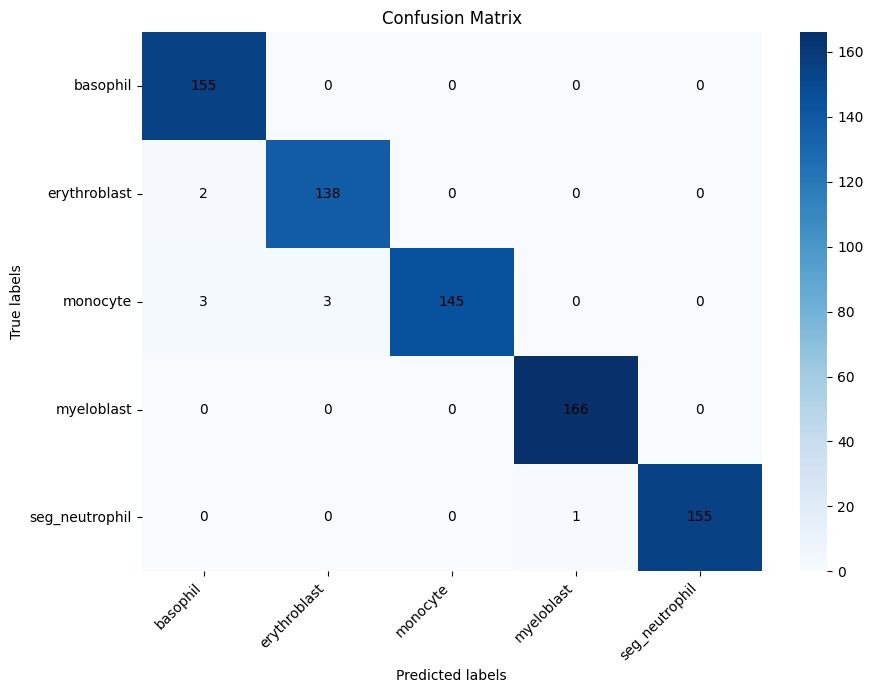

In [32]:
# 1. Generate Predictions
predictions = model.predict(test_ds)
predicted_classes = np.argmax(predictions, axis=1)

# 2. Prepare True Labels
true_labels = []
for images, labels in test_ds.unbatch():
    true_labels.append(labels.numpy())
true_labels = np.array(true_labels)

class_names = ['basophil', 'erythroblast', 'monocyte', 'myeloblast', 'seg_neutrophil']

plt.figure(figsize=(10, 7))
cm = confusion_matrix(true_labels, predicted_classes)
heatmap = sns.heatmap(cm, cmap="Blues", xticklabels=class_names, yticklabels=class_names, annot=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)

for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        text = heatmap.text(j + 0.5, i + 0.5, cm[i, j],
                            ha="center", va="center", color="black")

plt.show()

In [33]:
report = classification_report(true_labels, predicted_classes, target_names=class_names)
print(report)

print("Test loss:", loss)
print("Test accuracy:", accuracy)

                precision    recall  f1-score   support

      basophil       0.97      1.00      0.98       155
  erythroblast       0.98      0.99      0.98       140
      monocyte       1.00      0.96      0.98       151
    myeloblast       0.99      1.00      1.00       166
seg_neutrophil       1.00      0.99      1.00       156

      accuracy                           0.99       768
     macro avg       0.99      0.99      0.99       768
  weighted avg       0.99      0.99      0.99       768

Test loss: 0.5237025618553162
Test accuracy: 0.98828125


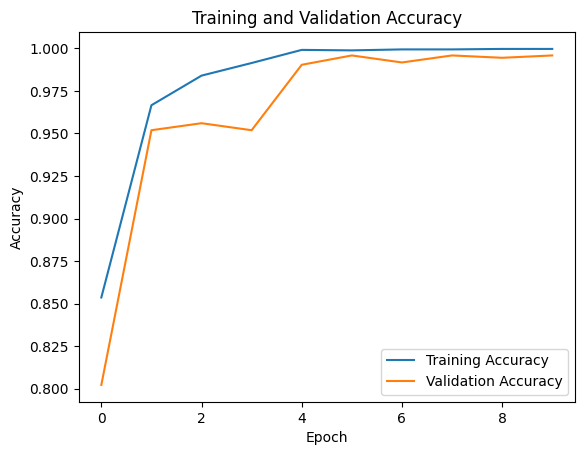

In [34]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

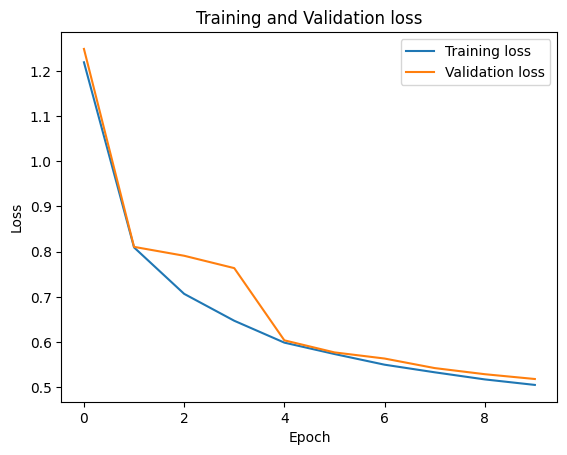

In [35]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation loss')
plt.legend()
plt.show()

In [36]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name):
    grad_model = Model(
        inputs=[model.inputs],
        outputs=[model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        class_idx = tf.argmax(predictions[0])
        loss = predictions[:, class_idx]

    grads = tape.gradient(loss, conv_outputs)

    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    heatmap = tf.maximum(heatmap, 1e-10)
    heatmap /= tf.math.reduce_max(heatmap)
    return heatmap.numpy()

In [37]:
def display_gradcam(img, heatmap, alpha=0.4):
    heatmap = np.maximum(heatmap, 0) / np.max(heatmap)

    heatmap = np.expand_dims(heatmap, axis=-1)
    heatmap = np.expand_dims(heatmap, axis=0)

    heatmap = tf.image.resize(heatmap, (img.shape[0], img.shape[1]))
    heatmap = np.squeeze(heatmap)

    heatmap = np.uint8(255 * heatmap)
    heatmap = plt.get_cmap('jet')(heatmap)[:, :, :3]
    heatmap = np.float32(heatmap) * 255

    cam_img = heatmap * alpha + np.float32(img)
    cam_img = np.clip(cam_img, 0, 255).astype(np.uint8)

    return cam_img

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['keras_tensor_120']]
Received: inputs=Tensor(shape=(1, 128, 128, 3))
  warnings.warn(msg)


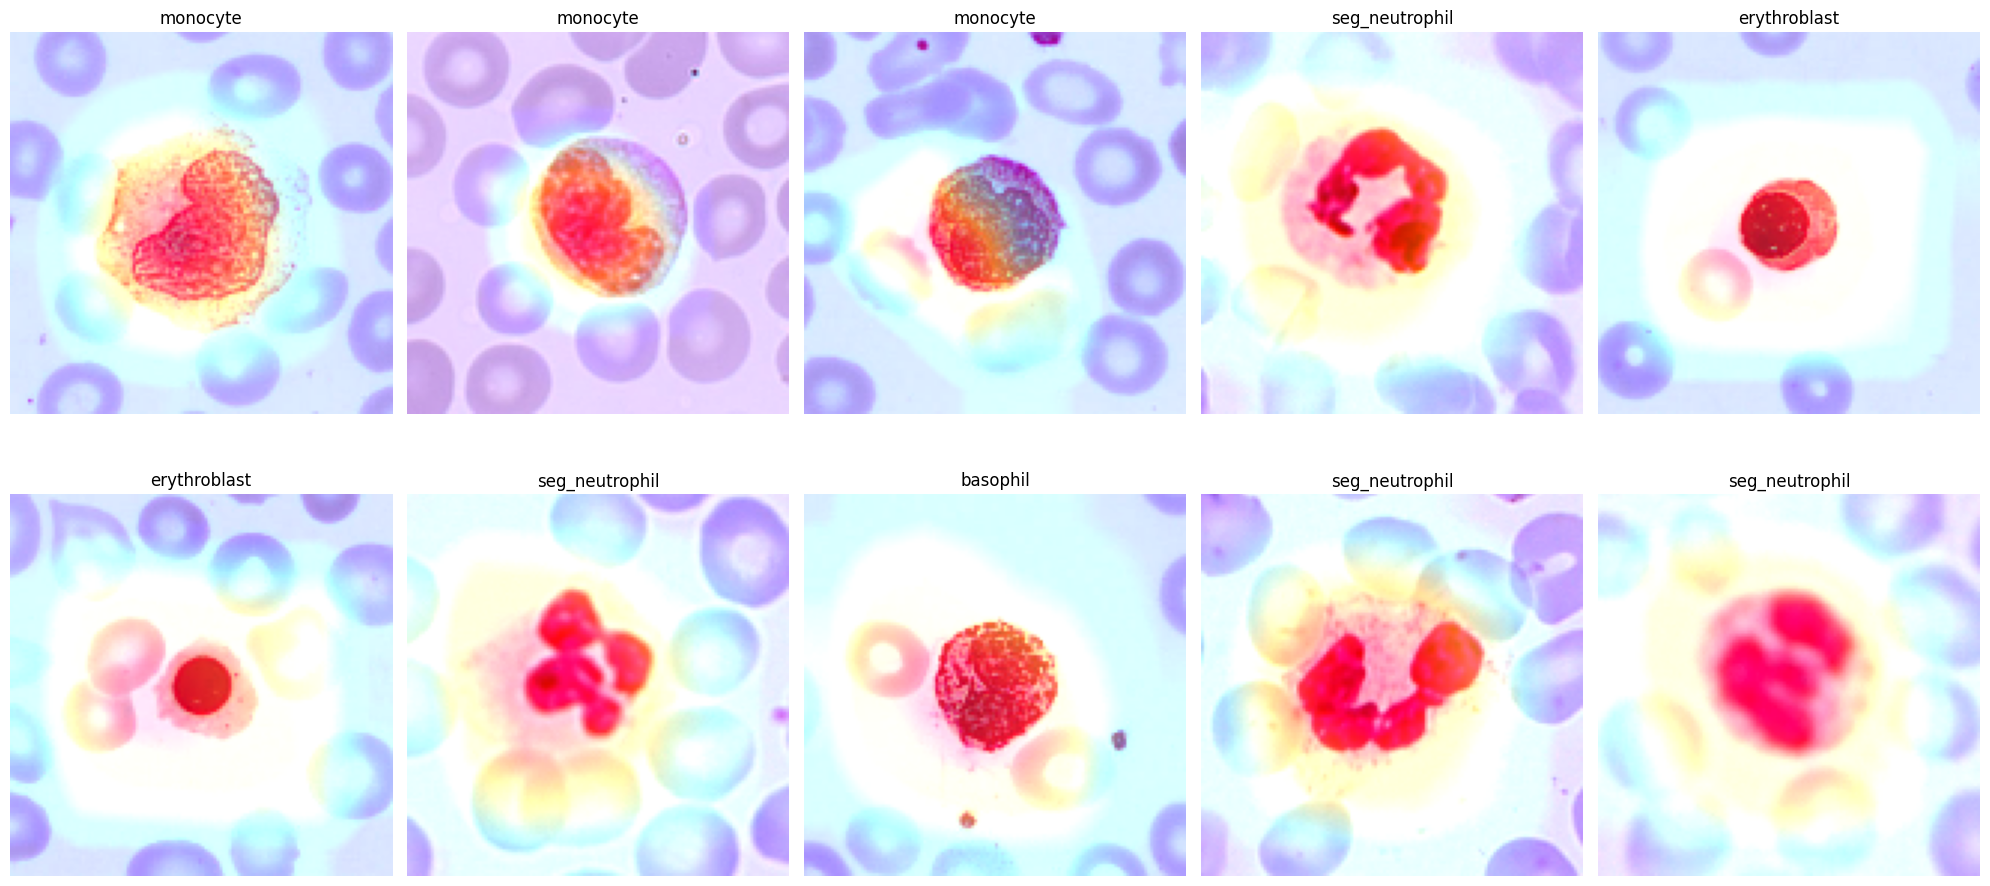

In [39]:
for images, labels in dataset.take(1):
    plt.figure(figsize=(20, 10))
    num_images = min(10, images.shape[0])

    for i in range(num_images):
        ax = plt.subplot(2, 5, i + 1)
        img_tensor = images[i:i+1]
        img = img_tensor[0].numpy()
        img = ((img - img.min()) / (img.max() - img.min()) * 255).astype("uint8")

        heatmap = make_gradcam_heatmap(img_tensor, model, 'conv2d_30')

        cam_img = display_gradcam(img, heatmap)

        plt.imshow(cam_img)
        plt.title(class_names[int(labels[i])])
        plt.axis("off")

    plt.tight_layout()
    plt.show()
    break